###### 2020-11-24 화요일

# 03_1D-CNN



 - 구글 collab으로 실행하였습니다

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import re
import json

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split

## 1. 데이터불러오기 & 합치기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
feature = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/feature.csv', index_col=[0])
target = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/target.csv', index_col=[0])

word_index_json = open('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/word_index_vocab.json', 'r').read()
word_index_vocab = json.loads(word_index_json)

## 2. 데이터토큰화 & 패딩

#### 텍스트 음절단위로 자르기

In [5]:
feature_split = feature['댓글'].apply(list).tolist()

#### 정수인덱싱

In [6]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index_vocab

feature_sequences = tokenizer.texts_to_sequences(feature_split)

### 패딩

In [7]:
feature_input = pad_sequences(feature_sequences, padding='post', maxlen=400)

## 3. SMOTE를 이용한 라벨 불균형 해소

In [8]:
target.value_counts()

악플여부
0       76691
1       38128
dtype: int64

 - 라벨 0은 446162, 1은 2897, 2는 4993으로 균형이 잡혀있지않아 recall(재현율)이 떨어질 가능성이 높다
 - 그래서 SMOTE를 이용하여 라벨이 1과 2인 경우를 복제하여 라벨학습의 균형을 맞추어 주는 것이다
 - 이것을 `오버샘플링`이라 한다.

In [ ]:
# from imblearn.over_sampling import SMOTE

In [ ]:
# smote = SMOTE(random_state=123)
# feature_over, target_over = smote.fit_sample(feature_input, target)

In [ ]:
# pd.Series(target_over).value_counts()

1    67435
0    67435
dtype: int64

In [ ]:
# target_over = target_over.reshape(-1, 1)

In [9]:
feature_over = np.array(feature_input)
target_over = np.array(target)

## 4. 1D-CNN + K-Fold 구현

In [10]:
import tensorflow.keras.backend as K
# Mish 활성화 함수
def mish(x):
    return x * K.tanh(K.softplus(x))

In [11]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score

In [12]:
vocab_size = len(word_index_vocab)
embedding_dim = 128
comment_len = 400

In [13]:
def get_model() :

    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Flatten, MaxPool1D, GlobalAveragePooling1D, Flatten

    model = Sequential()
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=comment_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 3, padding='same', activation=mish, strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation=mish))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

    return model

In [14]:
# 3-Fold 시행
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)

In [15]:
validation_pred = np.zeros((feature_over.shape[0], 1))


k = 0
for train_idx, val_idx in tqdm_notebook(cv.split(feature_over, target_over)) :

    print('{}번째 Fold 시작' .format(k+1))

    x_train = feature_over[train_idx]
    y_train = target_over[train_idx]

    x_validation = feature_over[val_idx]
    y_validation = target_over[val_idx]

    CNN = get_model()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

    CNN.fit(x_train, y_train,
             callbacks          = [es],
             epochs             = 20,
             batch_size         = 64,
             validation_data    = (x_validation, y_validation))
    
    validation_pred[val_idx, : ] = CNN.predict(x_validation) 
    print('')

    k += 1

1번째 Fold 시작
Epoch 1/20
1197/1197 [==============================] - 26s 16ms/step - loss: 0.3390 - accuracy: 0.8568 - val_loss: 0.1979 - val_accuracy: 0.9241
Epoch 2/20
1197/1197 [==============================] - 18s 15ms/step - loss: 0.2013 - accuracy: 0.9239 - val_loss: 0.1673 - val_accuracy: 0.9383
Epoch 3/20
1197/1197 [==============================] - 18s 15ms/step - loss: 0.1716 - accuracy: 0.9355 - val_loss: 0.1677 - val_accuracy: 0.9388
Epoch 4/20
1197/1197 [==============================] - 18s 15ms/step - loss: 0.1626 - accuracy: 0.9394 - val_loss: 0.1716 - val_accuracy: 0.9401
Epoch 00004: early stopping

2번째 Fold 시작
Epoch 1/20
1197/1197 [==============================] - 18s 15ms/step - loss: 0.3315 - accuracy: 0.8601 - val_loss: 0.2060 - val_accuracy: 0.9181
Epoch 2/20
1197/1197 [==============================] - 18s 15ms/step - loss: 0.2000 - accuracy: 0.9247 - val_loss: 0.1707 - val_accuracy: 0.9389
Epoch 3/20
1197/1197 [==============================] - 18s 15ms/step -

## 5. 모델 평가

In [16]:
y_prob = validation_pred
y_test = target_over

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer
import matplotlib.pyplot as plt

AUC는? : 0.9752744


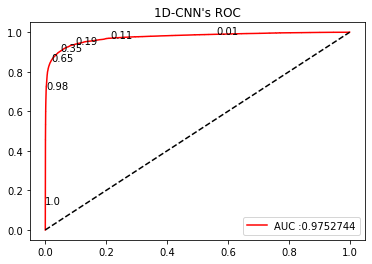

In [18]:
# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(y_test, y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 2000)


# ROC 그래프 그리기
plt.plot(fpr_array, tpr_array, 
         c = 'red', 
         label = "AUC :" + str(round(roc_auc_score(y_test, y_prob), 7)))
plt.plot([0, 1], [0,1], ls='--', c='black')
plt.title("1D-CNN's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)


# ROC의 auc는?
print('AUC는? :', round(roc_auc_score(y_test, y_prob), 7))

## 6. ROC 그래프 겹처서 그리기위해 데이터저장

In [19]:
data = {
    'fpr_array'       : fpr_array,
    'tpr_array'       : tpr_array,
    'threshold_array' : threshold_array
}

df = pd.DataFrame(data)

In [20]:
df.to_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/03_ROC_그래프/1D-CNN_ROC.csv')